In [1]:
#Import Packages
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spaCy for Lemmatization
import spacy

#Visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
#NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [3]:
#Import Dataset
import os
os.chdir("D:\Choogle\Data\dataset_review")
df = pd.read_csv(r'dataset2_london.csv')
reviews_datasets = df.head(20000)
print(reviews_datasets.text.unique())
df.head(2)

["The staff in this branch of Nando's were friendly and efficient. Despite being a fairly busy Friday night the wood arrived promptly and was up to the usual standard."
 'The most tasty chicken in town with their famous Piri piri sauce. Great new restaurant, very spacious, clean. Goid service. Avoid on Arsenal match days, too many people.'
 'Really surprised and pleased, very friendly and great beer, what more could you ask, plus warm on a wet cold day'
 ...
 "This restaurant has PHENOMENAL taquitos! The rest of the food is good. Our family of four including two young kids ate from their &quot;Street Food&quot; menu - which is smaller plates including tacos, quesadillas, and the aforementioned taquitos. While the other dishes we got (include Ancho chicken tacos, pork pibril tacos, and a coupla quesadillas) was definitely good, their shrimp and crab taquito and sweet potato and feta taquito were just unbelievably good. If I could / were to go back, I think I'd just order those taquitos 

,crayon_review_id,crayon_user_id,crayon_product_id,domain,url,type,category,date_created,gid,key,...,user_id,user_name,user_location_text,user_city,user_country,user_total_reviews,user_total_reviews_range,user_helpful_reviews,user_helpful_reviews_range,partition_0
0,RR-202001000-552550429,RU-302001000-806642411,R-102001000-202456154,item_1_saturam_restaurant_review_metadata_info,https://item_1_saturam_restaurant_review_metad...,Reviews,Restaurants,2019-04-11,item_1_saturam_restaurant_review_metadata_info...,ef65c514583b9254dbd8f794c516aaca21c864076d59e3...,...,732393D49A0A1F0B63E5037F07DCDA04,Stevetarn2014,"London, United Kingdom",London,United Kingdom,423,101 to 500,1030,1001 to 5000,item_1_restaurant_review_20190609_v10_stage4_c...
1,RR-202001000-550793573,RU-302001000-802600320,R-102001000-202456154,item_1_saturam_restaurant_review_metadata_info,https://item_1_saturam_restaurant_review_metad...,Reviews,Restaurants,2019-04-11,item_1_saturam_restaurant_review_metadata_info...,e766851ea18b154b154e419691d4ee7eeb4db9d80333f4...,...,2D0CF2077ADEDA59A706B7E1E3DE26E6,T35BZcristinag,NaN,NaN,NaN,141,101 to 500,9,1 to 100,item_1_restaurant_review_20190609_v10_stage4_c...


In [4]:
#Convert to list
data = df.text
pprint(data[:4])
data[0]

0    The staff in this branch of Nando's were frien...
1    The most tasty chicken in town with their famo...
2    Really surprised and pleased, very friendly an...
3    Having interred my late wife’s ashes in Totten...
Name: text, dtype: object


"The staff in this branch of Nando's were friendly and efficient. Despite being a fairly busy Friday night the wood arrived promptly and was up to the usual standard."

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'staff', 'in', 'this', 'branch', 'of', 'nando', 'were', 'friendly', 'and', 'efficient', 'despite', 'being', 'fairly', 'busy', 'friday', 'night', 'the', 'wood', 'arrived', 'promptly', 'and', 'was', 'up', 'to', 'the', 'usual', 'standard']]


In [6]:
reviews_datasets['text'][0]

"The staff in this branch of Nando's were friendly and efficient. Despite being a fairly busy Friday night the wood arrived promptly and was up to the usual standard."

In [7]:
#Building Bigram and Trigram Models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) #higher threshold fewer phrases
trigram = gensim.models.Phrases((bigram[data_words]), threshold=5)

#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#Trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'staff', 'in', 'this', 'branch', 'of', 'nando', 'were', 'friendly_and_efficient', 'despite_being', 'fairly', 'busy', 'friday_night', 'the', 'wood', 'arrived', 'promptly', 'and', 'was', 'up', 'to', 'the', 'usual', 'standard']


In [8]:
#Define functions for stopwords, bigrams, trigrams and Lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out    

In [9]:
import en_core_web_sm

#Remove Stope Words
data_words_nostops = remove_stopwords(data_words)

#Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

#Initialize spaCy 'en' model, keeping only tagger componenet (for efficiency)
nlp = en_core_web_sm.load()

#Doing lemmatization - keeping only noun, adj, adv, vb
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:4])

[['friendly', 'efficient', 'fairly', 'busy', 'wood', 'arrive', 'promptly', 'usual', 'standard'], ['tasty', 'town', 'famous', 'new', 'restaurant', 'spacious', 'service', 'avoid', 'arsenal', 'match', 'day', 'many_people'], ['really', 'surprise', 'please', 'friendly', 'great', 'beer', 'could', 'ask', 'warm', 'wet', 'cold', 'day'], ['interred', 'late', 'wife', 'ash', 'chef', 'provide', 'family', 'also', 'manage', 'accommodate', 'lone', 'admirably', 'service', 'help', 'relax', 'emotional', 'morning', 'thank', 'make', 'welcome']]


In [10]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#Create Corpus
texts = data_lemmatized

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [11]:
id2word[3]

'fairly'

In [12]:
#Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('arrive', 1),
  ('busy', 1),
  ('efficient', 1),
  ('fairly', 1),
  ('friendly', 1),
  ('promptly', 1),
  ('standard', 1),
  ('usual', 1),
  ('wood', 1)]]

In [13]:
#Build LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
#Print the keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"many" + 0.034*"big" + 0.030*"birthday" + 0.025*"french" + '
  '0.021*"enough" + 0.018*"course" + 0.018*"amount" + 0.017*"meat" + '
  '0.017*"daughter" + 0.016*"kid"'),
 (1,
  '0.047*"food" + 0.030*"good" + 0.024*"great" + 0.019*"go" + 0.018*"service" '
  '+ 0.017*"place" + 0.017*"restaurant" + 0.015*"staff" + 0.011*"dish" + '
  '0.011*"menu"'),
 (2,
  '0.048*"one" + 0.042*"worth" + 0.033*"lively" + 0.033*"highly_recommende" + '
  '0.026*"rice" + 0.018*"toilet" + 0.017*"house" + 0.017*"happen" + '
  '0.016*"professional" + 0.015*"conversation"'),
 (3,
  '0.017*"behaviour" + 0.016*"aware" + 0.012*"firstly" + 0.011*"description" + '
  '0.006*"posh" + 0.003*"baby" + 0.000*"bully" + 0.000*"claustrophobic" + '
  '0.000*"traumatise" + 0.000*"criminal"'),
 (4,
  '0.042*"quick" + 0.028*"fantastic" + 0.027*"group" + 0.026*"beer" + '
  '0.024*"especially" + 0.022*"money" + 0.022*"fun" + 0.020*"mean" + '
  '0.019*"pub" + 0.019*"would_recommend"'),
 (5,
  '0.054*"value" + 0.040*"tequ

In [15]:
#Compute Perplexity
print('\n Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. Lower is better.

#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score: ', coherence_lda)


 Perplexity:  -7.652245286858429

 Coherence Score:  0.44129730737078593


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.ldamodel.LdaModel(lda_model, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values 

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

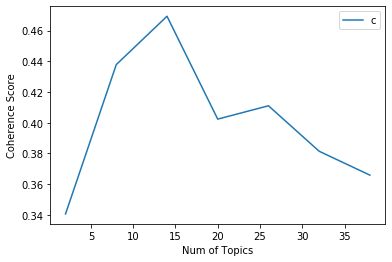

In [19]:
#Graph
limit=40; start=2; step=6;
x=range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
#Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num of Topics = ", m, "has Coherence Value of ", round(cv,10))

Num of Topics =  2 has Coherence Value of  0.3405606801
Num of Topics =  8 has Coherence Value of  0.4378233733
Num of Topics =  14 has Coherence Value of  0.4693364216
Num of Topics =  20 has Coherence Value of  0.4023208192
Num of Topics =  26 has Coherence Value of  0.4110151669
Num of Topics =  32 has Coherence Value of  0.3813779827
Num of Topics =  38 has Coherence Value of  0.3658140589


In [21]:
#Select the Model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.107*"many" + 0.068*"happy" + 0.049*"daughter" + 0.048*"easy" + '
  '0.047*"mix" + 0.038*"pop" + 0.036*"team" + 0.036*"wish" + 0.034*"owner" + '
  '0.030*"head"'),
 (1,
  '0.039*"table" + 0.037*"order" + 0.028*"come" + 0.027*"dish" + 0.027*"wait" '
  '+ 0.024*"restaurant" + 0.022*"drink" + 0.022*"get" + 0.021*"would" + '
  '0.021*"eat"'),
 (2,
  '0.137*"fun" + 0.091*"one" + 0.063*"lively" + 0.038*"game" + 0.030*"sausage" '
  '+ 0.028*"conversation" + 0.005*"mash" + 0.000*"night" + 0.000*"wahaca" + '
  '0.000*"mexican"'),
 (3,
  '0.029*"next_time" + 0.010*"spirit" + 0.006*"package" + 0.000*"mind" + '
  '0.000*"soo" + 0.000*"seanend" + 0.000*"blow" + 0.000*"come_back" + '
  '0.000*"wine" + 0.000*"spot"'),
 (4,
  '0.063*"small" + 0.062*"fresh" + 0.049*"helpful" + 0.047*"enjoy" + '
  '0.042*"different" + 0.041*"quick" + 0.030*"big" + 0.027*"walk" + '
  '0.025*"beer" + 0.025*"chain"'),
 (5,
  '0.108*"spend" + 0.068*"live" + 0.051*"modern" + 0.034*"elsewhere" + '
  '0.021*"normal" +

In [22]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Conda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.368025  0.156230       1        1  54.942982
6     -0.280049 -0.221326       2        1  21.898565
7      0.045349  0.247652       3        1   6.058388
4      0.089318 -0.004581       4        1   4.755196
0      0.084613 -0.101154       5        1   4.220084
9      0.099390 -0.022472       6        1   3.369166
8      0.098005 -0.014286       7        1   3.269398
5      0.081386 -0.014534       8        1   0.698446
2      0.080446 -0.014301       9        1   0.676723
3      0.069566 -0.011228      10        1   0.111048, topic_info=     Category         Freq        Term        Total  loglift  logprob
53    Default  1329.000000        food  1329.000000  30.0000  30.0000
271   Default   501.000000       order   501.000000  29.0000  29.0000
136   Default   515.000000       table   515.000000  28.0000  28.0000
134   Default   182.000000       small   182.000000  27.0000  27.0000
54    Default   841.000000        good   841.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
4728  Topic10     0.011847      latino     0.852259   2.5271  -8.4798
4727  Topic10     0.011847  adequately     0.852259   2.5271  -8.4798
4732  Topic10     0.011847     speaker     0.852259   2.5271  -8.4798
4731  Topic10     0.011847      shrimp     0.852259   2.5271  -8.4798
4733  Topic10     0.011847       tempo     0.852259   2.5271  -8.4798

[376 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
33        1  0.995314             also
66        1  0.998440           always
1050      8  0.917450         ambience
625       5  0.979287           amount
3579      9  0.480042            ample
...     ...       ...              ...
142       2  0.759972            would
160       8  0.901255     would_highly
225       4  0.989665  would_recommend
1104      5  0.947294            write
170       4  0.954944              yet

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 5, 1, 10, 9, 6, 3, 4])